In [115]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')

In [14]:
df = pd.read_csv('../data/processed/cleaned_data.csv')
df.head()

/home/maureen/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Datetime,X,Y,OBJECTID,INCKEY,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,PERSONCOUNT,...,WEATHER,ROADCOND,LIGHTCOND,ST_COLCODE,ST_COLDESC,CROSSWALKKEY,SPEEDING_Y,INATTENTIONIND_Y,HITPARKEDCAR_Y,PEDROWNOTGRNT_Y
0,2003-10-06,-122.320755,47.608073,1680,3663,Intersection,29797.0,BROADWAY AND CHERRY ST,0,0,...,0,0,0,NaN,NaN,0,0,0,0,1
1,2004-01-01,NaN,NaN,16515,29248,NaN,NaN,NaN,0,0,...,0,0,0,NaN,NaN,0,0,0,0,0
2,2004-01-01,-122.313520,47.601688,9624,22796,Block,NaN,E YESLER WAY BETWEEN 14TH AVE AND 15TH AVE,0,0,...,0,0,0,NaN,NaN,0,0,0,0,0
3,2004-01-01,-122.360959,47.571594,11719,25538,Block,NaN,WEST SEATTLE BR WB BETWEEN W SEATTLE BR WB OFF...,0,0,...,0,0,0,NaN,NaN,0,0,0,0,0
4,2004-01-01,-122.337454,47.615057,13533,27177,Intersection,29540.0,7TH AVE AND VIRGINIA ST,0,0,...,0,0,0,NaN,NaN,0,0,0,0,0


In [79]:
# Drop columns and check NaN
to_drop = ['Datetime', 'X', 'Y', 'OBJECTID', 'INCKEY', 'ADDRTYPE', 'LOCATION', 
           'INCDATE', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'ST_COLCODE', 'INTKEY',
           'ST_COLDESC', 'PERSONCOUNT']
data = df.drop(columns=to_drop)
data.isnull().sum()

SEVERITYCODE        0
PEDCOUNT            0
PEDCYLCOUNT         0
VEHCOUNT            0
INJURIES            0
SERIOUSINJURIES     0
FATALITIES          0
UNDERINFL           0
WEATHER             0
ROADCOND            0
LIGHTCOND           0
CROSSWALKKEY        0
SPEEDING_Y          0
INATTENTIONIND_Y    0
HITPARKEDCAR_Y      0
PEDROWNOTGRNT_Y     0
dtype: int64

## Start the model
1. Define target based on our business case
2. Create train/test split
3. Train model
4. Evaluate metrics

In [80]:
# Define our target. In this case can use severity code. If there are injuries, == 1
data['SEVERITYCODE'].value_counts()
data['INJURIES_OCCURED'] = (data['SEVERITYCODE'] == 2).astype(int)

In [81]:
y = data.pop('INJURIES_OCCURED')
X = data.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'])
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [ ]:
sns.heatmap()

In [83]:
# Create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify configuration
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
}

gbm = lgb.train(params, 
                lgb_train, 
                num_boost_round=20, 
                valid_sets=lgb_eval, 
                early_stopping_rounds=5)

gbm.save_model('lgbm_model.txt')

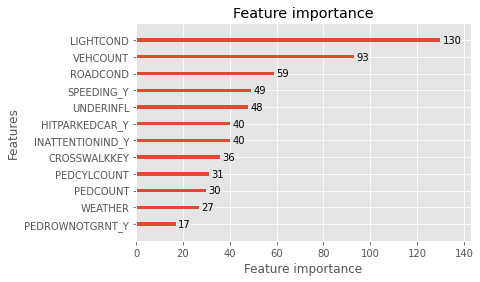

In [95]:
# Get feature importances
lgb.plot_importance(gbm)

In [100]:
# Do prediction and get AUC score
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
roc_auc_score(y_test, y_pred)

0.7355412761007113

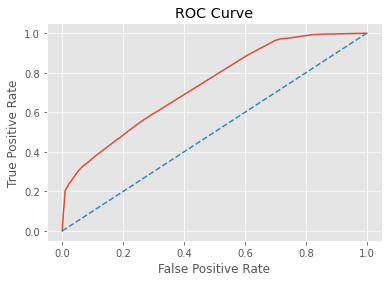

In [113]:
# Plot AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')

In [114]:
thresholds

array([1.71221945, 0.71221945, 0.70611282, 0.70448599, 0.7040459 ,
       0.70154755, 0.70001707, 0.69826867, 0.69800013, 0.69786871,
       0.69610407, 0.69598873, 0.69596375, 0.69526122, 0.69438176,
       0.69426485, 0.69330971, 0.69323274, 0.69238654, 0.69207011,
       0.69164741, 0.69146223, 0.69042123, 0.68961185, 0.68942011,
       0.6890428 , 0.68882279, 0.6866051 , 0.68633956, 0.68517658,
       0.6849654 , 0.68322732, 0.68251841, 0.68219987, 0.67657645,
       0.67613204, 0.67502879, 0.67395012, 0.66837499, 0.66597173,
       0.66505573, 0.66209688, 0.66093062, 0.65942082, 0.65512187,
       0.65385989, 0.65330369, 0.65194586, 0.65016899, 0.64777794,
       0.64694532, 0.64591419, 0.64227207, 0.63994332, 0.63840442,
       0.63789408, 0.63603327, 0.63594565, 0.63548119, 0.63390578,
       0.63383265, 0.63327288, 0.63280751, 0.63233115, 0.63089365,
       0.63039327, 0.62764402, 0.62674603, 0.62673639, 0.62552842,
       0.62537582, 0.62471774, 0.62471267, 0.62365871, 0.62325